In [1569]:
import numpy as np
from matplotlib import pyplot as plt
import soundfile
from librosa import display
from librosa import load
from scipy import fft

In [1570]:
SAMPLES = (2**5)
FREQ_1 = 3
FREQ_2 = 11

In [1571]:
x = np.arange(SAMPLES)
y1 = np.sin(2*np.pi*FREQ_1*(x/SAMPLES))
y2 = np.sin(2*np.pi*FREQ_2*(x/SAMPLES))
y3 = y1 + y2

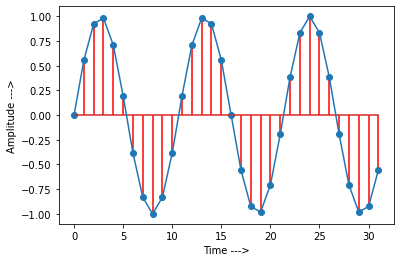

In [1572]:
plt.figure()
plt.stem(x, y1, 'r')
plt.plot(x,y1)
plt.xlabel("Time --->")
plt.ylabel("Amplitude --->")
plt.show()

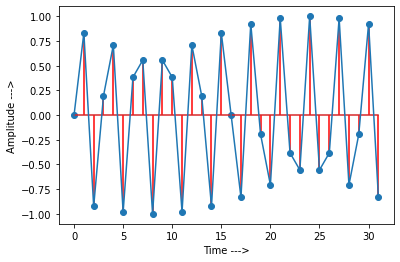

In [1573]:
plt.figure()
plt.stem(x, y2, 'r')
plt.plot(x,y2)
plt.xlabel("Time --->")
plt.ylabel("Amplitude --->")
plt.show()

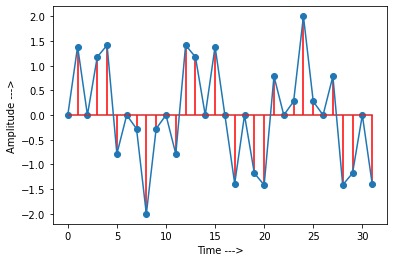

In [1574]:
plt.figure()
plt.stem(x, y3, 'r')
plt.plot(x,y3)
plt.xlabel("Time --->")
plt.ylabel("Amplitude --->")
plt.show()

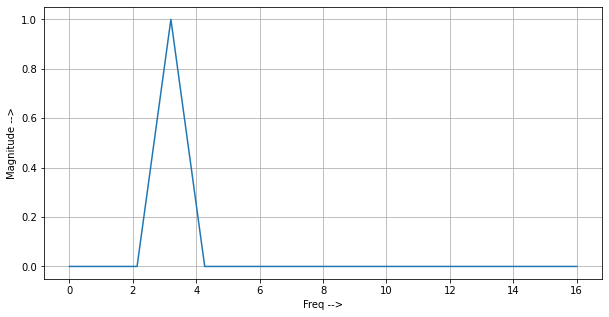

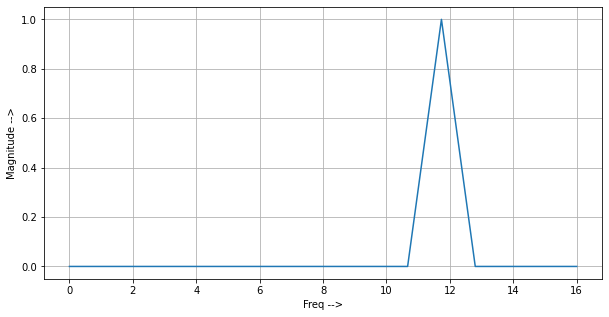

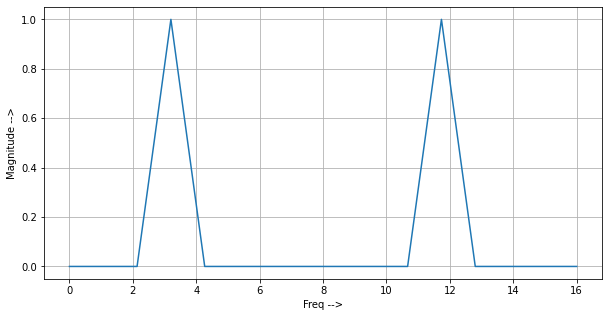

In [1575]:
def fft_plot(audio, sample_rate, figsize=(10,5)):
    n_samples = len(audio)
    T = 1/sample_rate
    # print(int(1/(2*T)))
    yf = fft.fft(audio)
    # only need one of the halfs as the other half is -ve of the half
    xf = np.linspace(0, int(1/(2*T)), n_samples//2)
    fig, ax = plt.subplots(figsize=figsize)
    yf_half = 2.0/n_samples * np.abs(yf[0:n_samples//2])
    ax.plot(xf, yf_half)
    plt.grid()
    plt.xlabel("Freq -->")
    plt.ylabel("Magnitude -->")
    return xf, yf, plt.show()

x1, y1_fft, y1_fft_plot = fft_plot(y1, sample_rate=SAMPLES)
x2, y2_fft, y2_fft_plot = fft_plot(y2, sample_rate=SAMPLES)
x3, y3_fft, y3_fft_plot = fft_plot(y3, sample_rate=SAMPLES)

In [1576]:
AUDIO_FILE_PATH = "../assets/band_audio_equed.wav"
AUDIO_OUTPUT_PATH = "../assets/output.wav"
# window size in ms
WINDOW_SIZE = 20

In [1577]:
AUDIO_SAMPLES, AUDIO_SR = load(AUDIO_FILE_PATH, sr=None, mono=True, offset=0.0, duration=None)
print(len(AUDIO_SAMPLES), AUDIO_SR)
from IPython.display import Audio
Audio(AUDIO_FILE_PATH)

60086 22050


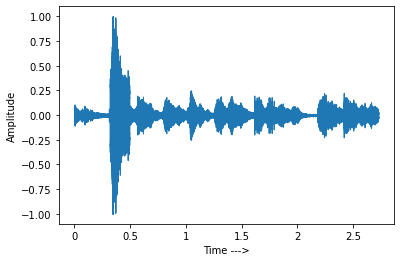

In [1578]:
plt.figure()
display.waveshow(y=AUDIO_SAMPLES, sr=AUDIO_SR)
plt.xlabel("Time --->")
plt.ylabel("Amplitude")
plt.show()

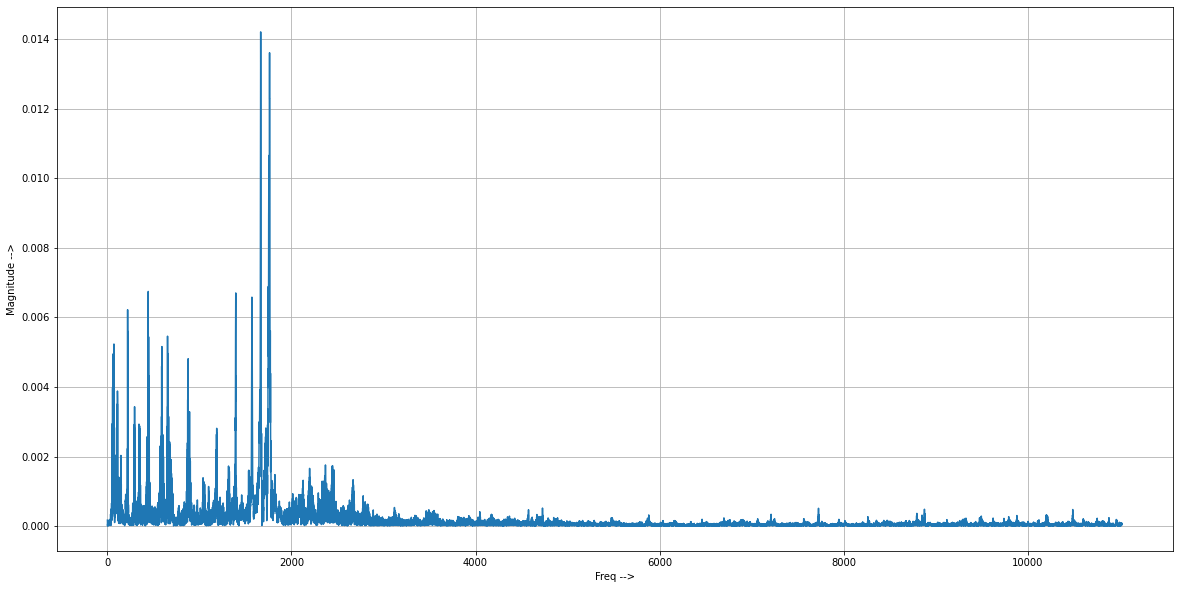

In [1579]:
x_audio, audio_fft,audio_fft_plot = fft_plot(audio=AUDIO_SAMPLES, sample_rate=AUDIO_SR, figsize=(20,10))

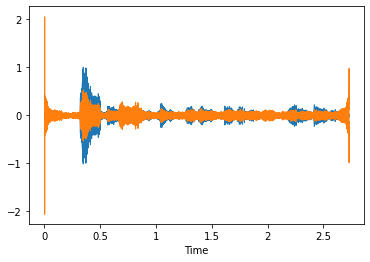

In [1580]:
audio_fft_filtered = np.clip(audio_fft, np.min(audio_fft), 0.007)


audio_ifft = fft.ifft(audio_fft_filtered)

display.waveshow(AUDIO_SAMPLES)
display.waveshow(audio_ifft.real)

In [1581]:
"""
sample_size = 8
window = 2
stride = window/2 = 1
windows => (0,1) (1,2) (2,3) (3,4) (4,5) (5,6) (7,8)
n_windows = sample_size - stride
"""

def numpy_make_windows(audio_samples, window_size):
    sample_size = len(audio_samples)
    stride_size = window_size//2

    truncate_size = (sample_size - window_size) % stride_size

    audio_samples = audio_samples[:(sample_size - truncate_size)]
    new_sample_size = sample_size - truncate_size
    nshape = (window_size, (new_sample_size - window_size) // stride_size + 1)
    nstrides = (audio_samples.strides[0], audio_samples.strides[0] * stride_size)
    np_windows = np.lib.stride_tricks.as_strided(audio_samples, shape = nshape, strides = nstrides)

    return np_windows

def make_windows(audio_samples, window_size):
    """
    Function to make overlapping windows with the given audio samples array
    """
    sample_size = len(audio_samples)
    stride_size = window_size//2
    n_windows = int(sample_size - stride_size) // stride_size
    # print(n_windows)

    windows = []

    for i in range(n_windows):
        w_ = audio_samples[i*stride_size:(i*stride_size+window_size)]
        windows.append(w_)
    
    # print("number of windows : ", windows.shape)
    windows = np.array(windows)
    windows = windows.T
    assert np.all(windows[:, 1] == audio_samples[stride_size:(stride_size + window_size)])
    
    np_windows = numpy_make_windows(audio_samples=audio_samples, window_size=window_size)
    # print(windows.shape)
    # assert np.all(windows[:, 1] == np_windows[:, 1])
    # print(windows[:, 1])
    # print(np_windows[:, 1])

    return n_windows, windows

window_size = int(WINDOW_SIZE*0.001*AUDIO_SR)
n_windows, windows = make_windows(audio_samples=AUDIO_SAMPLES, window_size=window_size)
print("WINDOWS SHAPE: ", windows.shape)


WINDOWS SHAPE:  (441, 272)


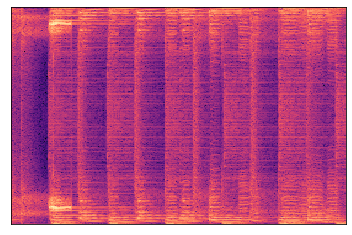

In [1582]:
# get weighting
weighting = np.hanning(window_size)[:, None]
# print(weighting)
# plt.plot(weighting)
# plt.show()
# plt.plot(1/weighting)
# plt.show()

windowed_fft = fft.fft(windows * weighting, axis=0)
# print(windowed_fft)

windowed_fft_half = np.absolute(windowed_fft)
# print(windowed_fft.shape, windowed_fft_half.shape)
# windowed_fft_half = windowed_fft_half ** 2
scale = np.sum(weighting ** 2) * AUDIO_SR
# print(scale)

windowed_fft_half[1:-1, :] *= (2.0 / scale)
windowed_fft_half[(0, -1), :] /= scale

freqs = float(AUDIO_SR) / window_size * np.arange(windowed_fft_half.shape[0])
# print(freqs)

ind = np.where(freqs <= np.max(freqs))[0][-1] + 1
# print(ind)
specgram = np.log(windowed_fft_half[:ind, :] + 1e-12)

# plt.plot(specgram)
# print(specgram)

# plt.specgram(x=specgram)
# plt.show()
# display.specshow(specgram,x_axis="time", y_axis="log",win_length=window_size, sr=AUDIO_SR)

display.specshow(specgram)

40.35191649007437
40.35191649007437
40.35191649007437


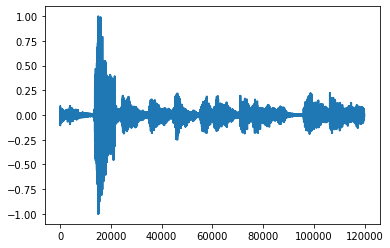

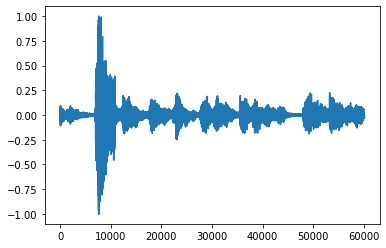

In [1583]:
# merge
final = np.array([])


wtf = windowed_fft

thresh = np.max(windowed_fft.flatten()).real
print(thresh)

for i in wtf:
    # posm_thresh = np.mean(i[i > 0]).real
    # negm_thresh = np.mean(i[i < 0]).real
    # # print(posm, negm)
    # pos_mask = (i > 0) & (i > posm_thresh)
    # neg_mask = (i < 0) & (i < negm_thresh)
    # i[pos_mask] *= 0.99999
    # i[neg_mask] *= 0.99999
    # i[abs(i) <= thresh] = 0
    for j in i:
        if abs(j.real) >= thresh:
            print(j.real)


windowed_ifft = fft.ifft(wtf, axis=0).real / (weighting[:len(windowed_fft)]+1e-9)

plt.plot(windowed_ifft.T.flatten())
plt.show()

plt.plot(AUDIO_SAMPLES)
plt.show()

soundfile.write(AUDIO_OUTPUT_PATH, windowed_ifft.T.flatten(), AUDIO_SR, subtype='PCM_24')

In [1584]:
Audio(AUDIO_OUTPUT_PATH)

In [1585]:
Audio(AUDIO_FILE_PATH)